In [1]:
import torch 
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm 
from torch.utils.data import DataLoader

from model import YOLOv1
from dataset import VOCDataset
from utils import (
    intersection_over_union,
    non_max_suppression,
    mean_average_precision,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)

from loss import YoloLoss

seed = 123
torch.manual_seed(seed)


#  -- Set --  #
Load_Model = True
Load_Model_File = "fit.pth.tar"

Learning_rate = 2e-5
Device = "cuda"
Batch_Size = 16
Weight_Decay = 0
Epoches = 100
Num_Worker = 0
PIN_memory = True

Img_Dir = "data/images/"
Label_dir = "data/labels/"
#  -- Set --  #

#  Transform  #
class Compose(object):
    def __init__(self,transforms) :
        self.transforms = transforms


    def __call__(self, img , bboxes ) :
        for t in self.transforms:
            img , bboxes = t(img) , bboxes
        return img, bboxes
transform = Compose([transforms.Resize((448,448)),transforms.ToTensor(),])

#  Transform  #

def Training (train_loader , model , optimizer , loss_fn ):
    loop = tqdm(train_loader , leave=True)
    mean_loss = []

    for batch_idx , (x,y)  in enumerate(loop):
        x , y = x.to(Device) , y.to(Device)
        out = model(x)
        loss = loss_fn(out ,y)
        mean_loss.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [2]:
model = YOLOv1(split_size=7, num_boxes=2, num_classes=20).to(Device)
optimizer = optim.Adam(
    model.parameters(), lr=Learning_rate, weight_decay=Weight_Decay
)

loss_fn = YoloLoss()

if Load_Model:
    load_checkpoint(torch.load(Load_Model_File), model, optimizer)


train_dataset = VOCDataset(
    "data/100examples.csv",
    transform=transform,
    img_dir=Img_Dir,
    label_dir=Label_dir,
)

test_dataset = VOCDataset(
    "data/test.csv", transform=transform, img_dir=Img_Dir, label_dir=Label_dir,
)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=Batch_Size,
    num_workers=Num_Worker,
    pin_memory=PIN_memory,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=Batch_Size,
    num_workers=Num_Worker,
    pin_memory=PIN_memory,
    shuffle=True,
    drop_last=True,
)


=> Loading checkpoint


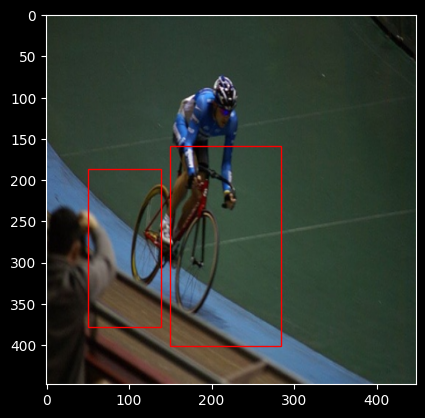

Image 70 - Predicted bounding boxes with class IDs:
Class ID: 4, BBox: [0.48527950048446655, 0.48367196321487427, 0.6244458556175232, 0.3005070090293884, 0.5392478108406067]
Class ID: 17, BBox: [0.4667222797870636, 0.21158644556999207, 0.6310359239578247, 0.19606563448905945, 0.42705997824668884]


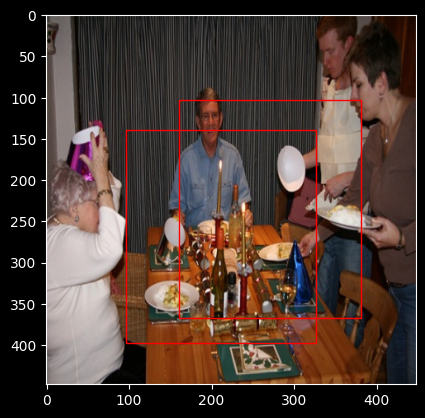

Image 71 - Predicted bounding boxes with class IDs:
Class ID: 14, BBox: [0.5638617277145386, 0.47174912691116333, 0.5989587306976318, 0.515739381313324, 0.5740954875946045]
Class ID: 14, BBox: [0.43729960918426514, 0.6056220531463623, 0.5237982869148254, 0.49260032176971436, 0.5900654792785645]


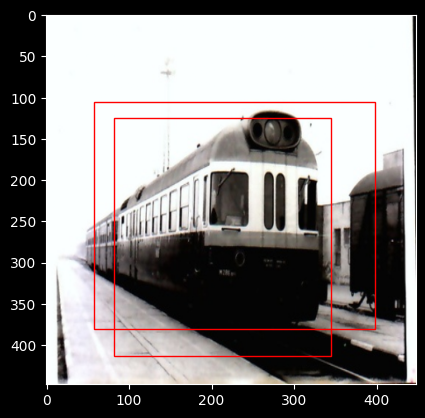

Image 72 - Predicted bounding boxes with class IDs:
Class ID: 14, BBox: [0.752157986164093, 0.5077730417251587, 0.5421905517578125, 0.7598420977592468, 0.6161456108093262]
Class ID: 17, BBox: [0.5108450651168823, 0.4756040871143341, 0.6012614965438843, 0.5874431729316711, 0.6442593932151794]


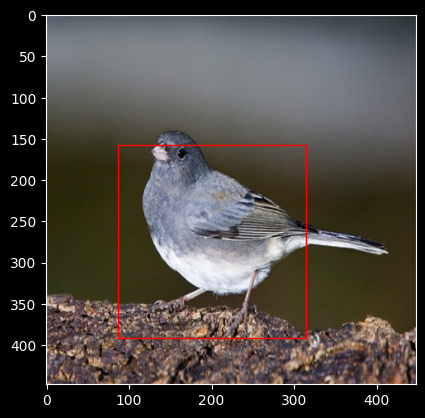

Image 73 - Predicted bounding boxes with class IDs:
Class ID: 14, BBox: [0.6587114334106445, 0.4484705328941345, 0.6126101613044739, 0.5088087320327759, 0.5233185887336731]


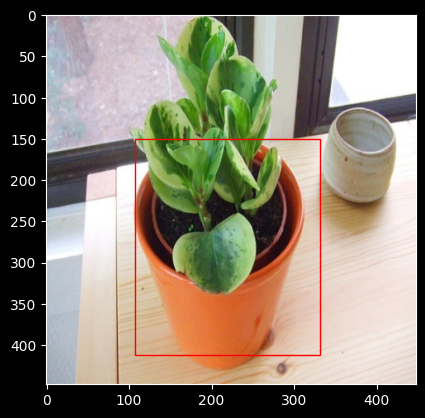

Image 74 - Predicted bounding boxes with class IDs:
Class ID: 13, BBox: [0.5851666331291199, 0.48917341232299805, 0.6266366839408875, 0.5017067790031433, 0.5841350555419922]


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from utils import VOC_CLASSES

start_idx = 70  # 起始索引
end_idx   = 75  # 結束索引




for i in range(start_idx, end_idx):
    img, label = test_dataset[i]
    img = img.unsqueeze(0).to(Device)  
    bboxes = cellboxes_to_boxes(model(img))
    bboxes = non_max_suppression(bboxes[0], iou_threshold=0.5, threshold=0.4, box_format="midpoint")

     
    plot_image(img[0].permute(1, 2, 0).to("cpu"), bboxes)

    print(f"Image {i} - Predicted bounding boxes with class IDs:")
    for bbox in bboxes:
        class_id = int(bbox[0])
        print(f"Class ID: {class_id}, BBox: {bbox[1:]}")
    

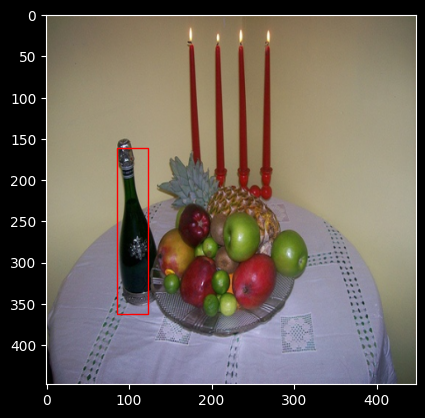

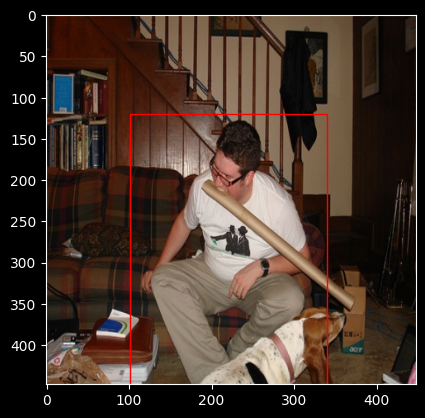

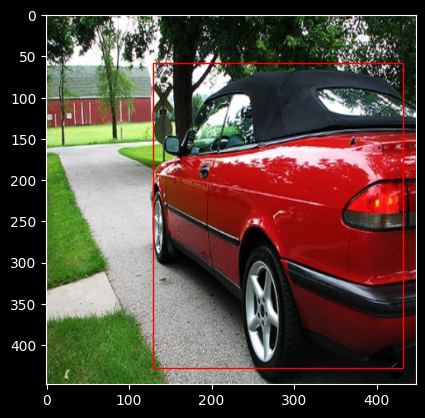

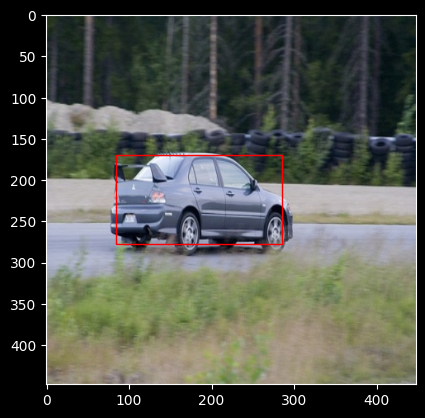

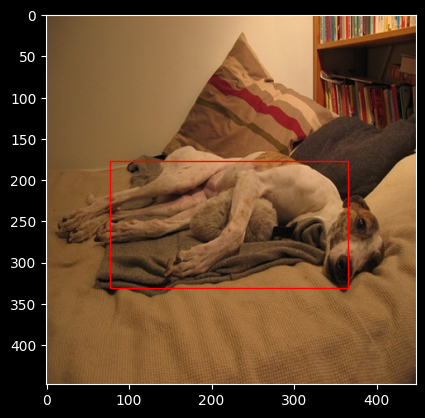

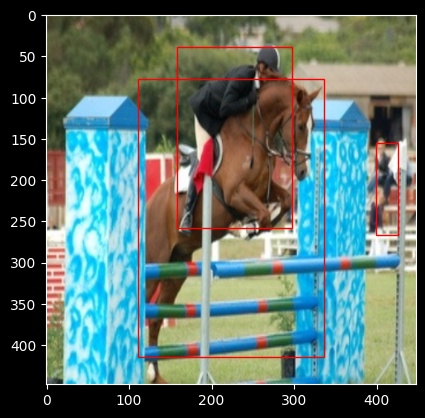

: 

In [ ]:
for x, y in train_loader:
    x = x.to(Device)
    for idx in range(1):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

    #import sys
    exit()